Discussed this assignment with Hyun In Park, Sang Hoon Kim, and Heeseung Hwang  

Submission for Q4 is lengthy since I included a number of plots for clustering results with various values for k.

**Preliminary setup:**

In [2]:
import string
import json
import re
import unidecode
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [3]:
speech = []

with open("speeches.json") as f:
    
    for line in f:
        speech.append(json.loads(line))
    
    f.close()

**Part (a):**  

Used a slightly modified version of the word-splitting function given in the problem set.

In [4]:
def text_process(raw):
    '''
    Takes the raw SOU script and processes into the analysis-freindly format.
    Modified the sample code given in the problem set at my discretion.
    Especially, I excluded "words" that consists of numbers (i.e. digits) only.
    '''
    punc_set = set(string.punctuation)
    raw = unidecode.unidecode(raw).lower().replace("-", " ")
    
    for punc in punc_set:    
        raw = raw.replace(punc, " ")
    
    raw = re.sub("(\r\n)+", " ", raw)
    raw = re.sub(' +',' ', raw.strip())
    
    return raw.split(" ")

In [5]:
def count_appear(sou, word):
    '''
    Counts the number of times a specified word has appeared in the given SOU
    '''
    count = 0
    
    for vocab in sou["post"]:
        if vocab == word:
            count += 1
    
    return count

In [6]:
def compute_tfidf(sou):
    '''
    Computes given SOU's TF-IDF vector
    '''
    tfidf = []
    
    for tup in v_count:

        n = sou["post"].count(tup[0])
        sum_exist = exist_count[tup[0]]
        coord = n * np.log(len(speech) / sum_exist)
        tfidf.append(coord)
    
    return np.array(tfidf)

In [7]:
all_words, word_count = [], dict()

for sou in speech:
    
    post_process = text_process(sou["text"])
    sou["post"] = " ".join(post_process)
    sou["post_set"] = set(post_process)
    all_words += post_process


for word in all_words:
    
    if not word in word_count:
        word_count[word] = 1
    
    else:
        word_count[word] += 1    
    
sort_count = list(word_count.items())

# Followed the vocabulary choice rule suggested in the problem set
# (Excluding 20 most common words & words with less than 50 times of sappearnce)

# v_count: vocabulary set & total times of appearnce
sort_count = sorted(sort_count, key = lambda x: x[1])[:-20]
v_count = [item for item in sort_count if item[1] >= 50]

# exist_count: total number of SOUs containing each word
exist_count = dict([(word[0], 0) for word in v_count])

for word in v_count:    
    for sou in speech:        
        if word[0] in sou["post_set"]:
            exist_count[word[0]] += 1


for sou in speech:
    sou["tfidf"] = compute_tfidf(sou)

**Part (b):**  

In [8]:
def similarity(vec1, vec2):
    '''
    Given two TF-IDF vectors, compute their similarity measure
    '''
    numer = np.dot(vec1, vec2)
    denom = np.linalg.norm(vec1) * np.linalg.norm(vec2)
    
    return (numer / denom)

In [9]:
def give_info(curr, targ):
    '''
    Returns the tuple of sou pairs (characterized by president and year)
    and similarity between two sous
    '''
    simil = similarity(curr["tfidf"], targ["tfidf"])
    info_curr = (curr["president"], curr["year"])
    info_targ = (targ["president"], targ["year"])

    return (info_curr, info_targ, simil)

In [10]:
def compute_pairs(current_sou, target_sou = None):
    '''
    For the specificed purpose (same or different president SOU comparison),
    construct sou pairs to compare and generates pair list with relevant information.
    '''
    pair_list = []
    
    if target_sou == None:
        
        for i in range(len(current_sou)):     
            consider = current_sou[i+1:]
            curr = current_sou[i]
            
            for targ in consider:                   
                pair_list.append(give_info(curr, targ))
     
    else:
        
        for curr in current_sou:
            for targ in target_sou:                
                pair_list.append(give_info(curr, targ))
    
    return pair_list

In [11]:
potus = dict()

for sou in speech:
    
    if not sou["president"] in potus:
        potus[sou["president"]] = {"sou": [sou]}
    
    else:
        potus[sou["president"]]["sou"].append(sou)

potus_list = list(potus.keys())
diff_pair, same_pair, potus_pair_semi = [], [], dict()

# Handling same president SOU pairs
for curr in potus_list:
    
    current_sou = potus[curr]["sou"]
    same_pair += compute_pairs(current_sou)


# Handling different president SOU pairs
for i in range(len(potus_list)):
    
    current_sou = potus[potus_list[i]]["sou"]
    consider = potus_list[i+1:]
    
    for target in consider:
        
        target_sou = potus[target]["sou"]
        diff_pair += compute_pairs(current_sou, target_sou)


# Handling president-president pairs
for case in diff_pair:
    
    pair = (case[0][0], case[1][0])
    
    if not pair in potus_pair_semi:
        potus_pair_semi[pair] = [case[2]]
    
    else:
        potus_pair_semi[pair].append(case[2])
    

for pair in potus_pair_semi:
    potus_pair_semi[pair] = np.mean(np.array(potus_pair_semi[pair]))


diff_pair = sorted(diff_pair, key = lambda x: x[2], reverse = True)
same_pair = sorted(same_pair, key = lambda x: x[2], reverse = True)
potus_pair = sorted(list(potus_pair_semi.items()), key = lambda x: x[1], reverse = True)

**50 most similar pairs of SOUs given by different Presidents:**

In [12]:
for i in range(49):
    print("{:s} ({:s})  and  {:s} ({:s})".format(diff_pair[i][0][0], diff_pair[i][0][1], diff_pair[i][1][0], diff_pair[i][1][1]))

Grover Cleveland (1885)  and  Martin Van Buren (1837)
Martin Van Buren (1837)  and  Andrew Jackson (1829)
Martin Van Buren (1837)  and  Millard Fillmore (1852)
Martin Van Buren (1837)  and  John Tyler (1842)
Rutherford B. Hayes (1880)  and  Chester A. Arthur (1881)
Franklin Pierce (1854)  and  Ulysses S. Grant (1875)
Andrew Jackson (1829)  and  Millard Fillmore (1852)
Rutherford B. Hayes (1880)  and  William Howard Taft (1912)
Martin Van Buren (1837)  and  John Tyler (1843)
James Buchanan (1858)  and  Millard Fillmore (1852)
Millard Fillmore (1852)  and  John Tyler (1842)
James K. Polk (1848)  and  Martin Van Buren (1837)
James K. Polk (1848)  and  Millard Fillmore (1851)
Andrew Jackson (1829)  and  John Tyler (1842)
William McKinley (1899)  and  Theodore Roosevelt (1903)
Grover Cleveland (1885)  and  Millard Fillmore (1851)
Grover Cleveland (1885)  and  Benjamin Harrison (1889)
Ulysses S. Grant (1870)  and  Andrew Jackson (1835)
James Buchanan (1858)  and  Martin Van Buren (1837)
Andr

**50 most similar pairs of SOUs given by the same President:**

In [13]:
for i in range(49):
    print("{:s} ({:s})  and  {:s} ({:s})".format(same_pair[i][0][0], same_pair[i][0][1], same_pair[i][1][0], same_pair[i][1][1]))

Barack Obama (2013)  and  Barack Obama (2012)
Theodore Roosevelt (1905)  and  Theodore Roosevelt (1907)
Franklin Pierce (1856)  and  Franklin Pierce (1855)
Andrew Jackson (1832)  and  Andrew Jackson (1829)
Theodore Roosevelt (1907)  and  Theodore Roosevelt (1906)
William Howard Taft (1909)  and  William Howard Taft (1912)
James Buchanan (1859)  and  James Buchanan (1858)
James Buchanan (1860)  and  James Buchanan (1857)
Theodore Roosevelt (1901)  and  Theodore Roosevelt (1904)
Ulysses S. Grant (1875)  and  Ulysses S. Grant (1874)
William McKinley (1899)  and  William McKinley (1898)
Rutherford B. Hayes (1879)  and  Rutherford B. Hayes (1880)
Theodore Roosevelt (1905)  and  Theodore Roosevelt (1906)
William Howard Taft (1911)  and  William Howard Taft (1912)
Grover Cleveland (1896)  and  Grover Cleveland (1888)
Benjamin Harrison (1890)  and  Benjamin Harrison (1891)
William Howard Taft (1909)  and  William Howard Taft (1911)
Theodore Roosevelt (1908)  and  Theodore Roosevelt (1906)
Andr

**25 most similar pairs of Presidents (by average of cosine similiarity over all SOU pairs):**

In [14]:
for i in range(24):
    print("{:s}  and  {:s}".format(potus_pair[i][0][0], potus_pair[i][0][1]))

Millard Fillmore  and  Zachary Taylor
John Tyler  and  Zachary Taylor
James Buchanan  and  Zachary Taylor
Andrew Jackson  and  John Tyler
Ulysses S. Grant  and  Zachary Taylor
James Buchanan  and  John Tyler
Abraham Lincoln  and  Rutherford B. Hayes
Andrew Jackson  and  Millard Fillmore
William McKinley  and  Rutherford B. Hayes
Ulysses S. Grant  and  Millard Fillmore
Millard Fillmore  and  John Tyler
Andrew Jackson  and  Zachary Taylor
Martin Van Buren  and  Millard Fillmore
Martin Van Buren  and  John Tyler
Rutherford B. Hayes  and  William Howard Taft
Benjamin Harrison  and  Rutherford B. Hayes
James Buchanan  and  Andrew Jackson
James Buchanan  and  Millard Fillmore
Martin Van Buren  and  Andrew Jackson
Rutherford B. Hayes  and  Chester A. Arthur
William McKinley  and  William Howard Taft
Martin Van Buren  and  Zachary Taylor
Abraham Lincoln  and  Benjamin Harrison
William McKinley  and  Benjamin Harrison


(Above results of "most similar n pairs" might change if I adopt different word-splitting rules and/or vocabulary-size.)

From the above results, 1885 SOU by Grover Cleveland, 1837 SOU by Martin Van Buren, and 1829 SOU by Andrew Jackson were analyzed to be 3 most similar SOUs based on TF-IDF vectors. When I read those three speeches, they were indeed similar in numerous aspects: allocating great portion from the beginning to discuss diplomatic situations, mostly with European countries, by frequently using the word "question" for the meaning of "issue" or "problem," just to give the most significant example.  
On the other hand, they also had some remarkable differences as well. One notable example is their difference in the beginning/introduction parts. Andrew Jackson's 1829 speech directly began with expressing the President's emotion (pleasure) towards the assembly; Martin Van Buren's 1837 SOU begins with expression of gratitude towards a religious being (probably God, although not explicitly mentioned); Grover Cleveland's 1885 speech actually begins with grief on death of the Vice President. While these speeches resembled each other in terms of overall organization of contents or diction, such subtle differences in nuances or emotional context were observable even at the first glance.  
Therefore, in order to construct a better similarity measure between documents, we should also take other linguistic factors of sentences into account as well -- namely positive/negative connotations, sentiment, or grammatical style/structure. (Of course, this will require not only sophisticated software but also deep expertise in linguistics, etc.)

**Part (c):**  
  
In this part, I will show the clustering results for k = 3, 5, 10, and 15.  
For visualization, I used "line chart," where $n_{th}$ integer point on the x-axis represents the $n_{th}$ coordinate of the high-dimensional TF-IDF vectors. (similar to the neuron voltage recording visualization from the class slides).

**(k=3 clustering)**

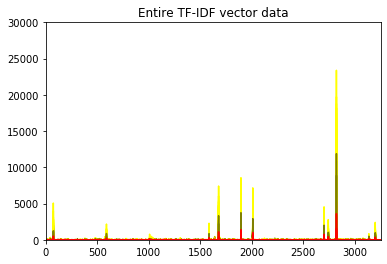

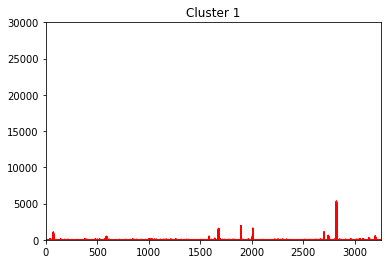

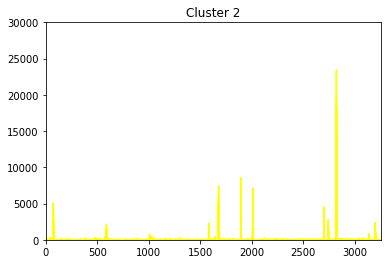

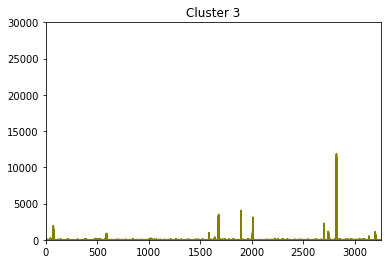

In [17]:
k = 3
iteration = 50
np.random.seed(1234)

vectors = np.zeros((len(speech), len(speech[0]["tfidf"])))

for i in range(len(speech)):
    vectors[i] = speech[i]["tfidf"]

# Shuffled the rows (vectors) randomly, so this is equivalent to drawing
np.random.shuffle(vectors)
centers = vectors[:k]

# for plotting: chose some colors that would match each culster
color_dict = {0: "#FF0000", 1: "#FFFF00", 2: "#808000", 3: "#00FF00",
              4: "#000080", 5: "#FF00FF", 6: "#B9770E", 7: "#1C2833",
              8: "#E67E22", 9: "#7FB3D5", 10: "#CD5C5C", 11: "#454545",
              12: "#999999", 13: "#800000", 14: "#AF7AC5"}

for i in range(iteration):
    
    model = KMeans(n_clusters = k, init = centers, n_init = 1, max_iter = 1)
    sou_cluster = model.fit(vectors)
    centers = model.cluster_centers_

match = model.predict(vectors)

df = pd.DataFrame(np.transpose(vectors), columns = match)
df.plot(color = [color_dict.get(x, "#333333") for x in df.columns], 
        legend = False, title = "Entire TF-IDF vector data", ylim = (0, 30000))
                            
for i in range(k):
    
    groupdf = df[i]
    groupdf.plot(color = color_dict[i], legend = False,
                 title = "Cluster {:d}".format(i+1), ylim = (0, 30000))

**(k=5 clustering)**

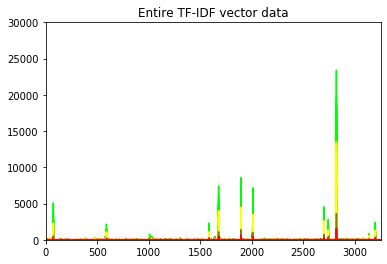

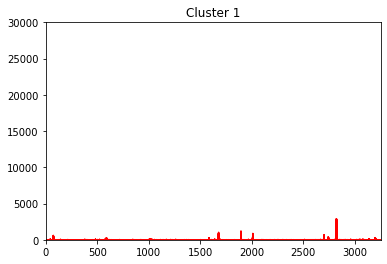

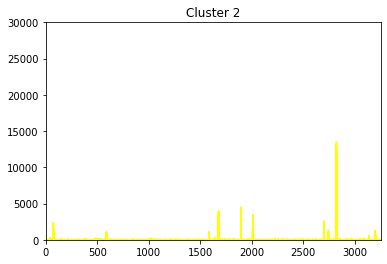

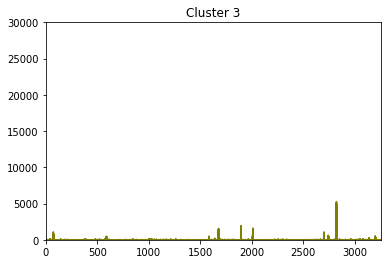

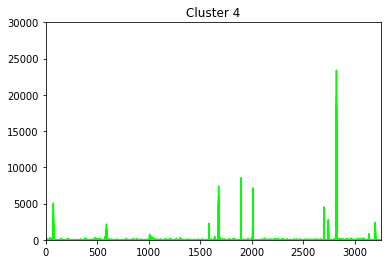

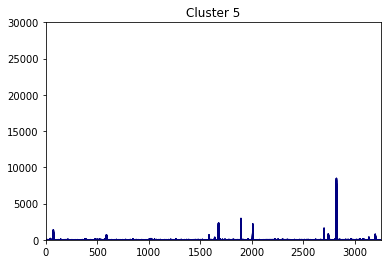

In [16]:
k = 5
iteration = 50
np.random.seed(1234)

vectors = np.zeros((len(speech), len(speech[0]["tfidf"])))

for i in range(len(speech)):
    vectors[i] = speech[i]["tfidf"]

# Shuffled the rows (vectors) randomly, so this is equivalent to drawing
np.random.shuffle(vectors)
centers = vectors[:k]

# for plotting: chose some colors that would match each culster
color_dict = {0: "#FF0000", 1: "#FFFF00", 2: "#808000", 3: "#00FF00",
              4: "#000080", 5: "#FF00FF", 6: "#B9770E", 7: "#1C2833",
              8: "#E67E22", 9: "#7FB3D5", 10: "#CD5C5C", 11: "#454545",
              12: "#999999", 13: "#800000", 14: "#AF7AC5"}

for i in range(iteration):
    
    model = KMeans(n_clusters = k, init = centers, n_init = 1, max_iter = 1)
    sou_cluster = model.fit(vectors)
    centers = model.cluster_centers_

match = model.predict(vectors)

df = pd.DataFrame(np.transpose(vectors), columns = match)
df.plot(color = [color_dict.get(x, "#333333") for x in df.columns], 
        legend = False, title = "Entire TF-IDF vector data", ylim = (0, 30000))
                            
for i in range(k):
    
    groupdf = df[i]
    groupdf.plot(color = color_dict[i], legend = False,
                 title = "Cluster {:d}".format(i+1), ylim = (0, 30000))

**(k=10 clustering)**

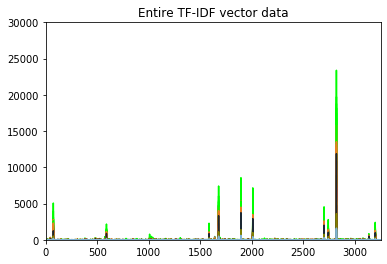

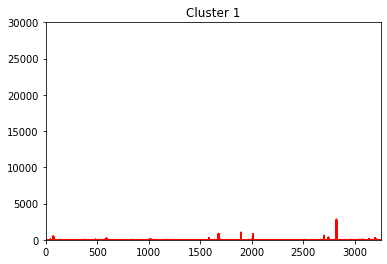

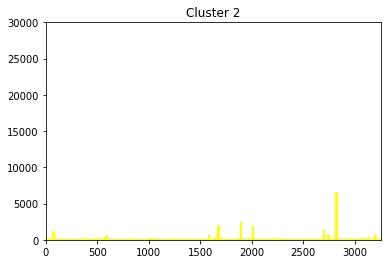

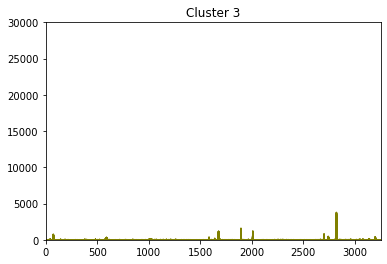

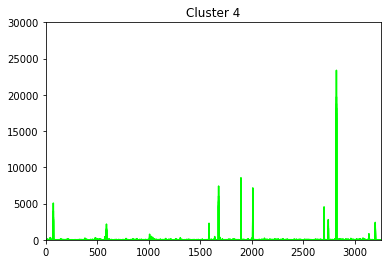

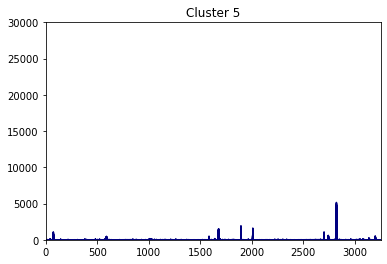

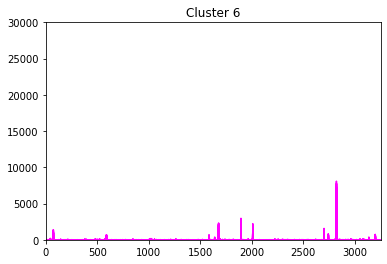

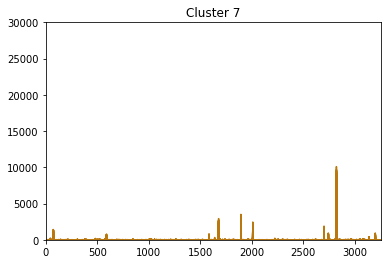

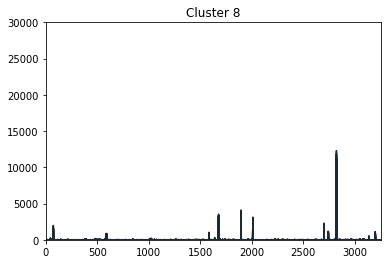

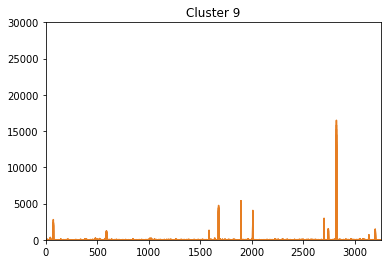

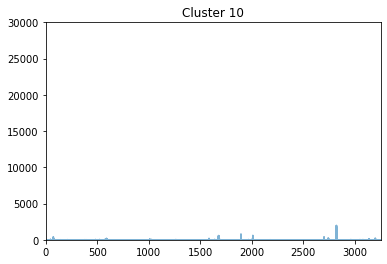

In [18]:
k = 10
iteration = 50
np.random.seed(1234)

vectors = np.zeros((len(speech), len(speech[0]["tfidf"])))

for i in range(len(speech)):
    vectors[i] = speech[i]["tfidf"]

# Shuffled the rows (vectors) randomly, so this is equivalent to drawing
np.random.shuffle(vectors)
centers = vectors[:k]

# for plotting: chose some colors that would match each culster
color_dict = {0: "#FF0000", 1: "#FFFF00", 2: "#808000", 3: "#00FF00",
              4: "#000080", 5: "#FF00FF", 6: "#B9770E", 7: "#1C2833",
              8: "#E67E22", 9: "#7FB3D5", 10: "#CD5C5C", 11: "#454545",
              12: "#999999", 13: "#800000", 14: "#AF7AC5"}

for i in range(iteration):
    
    model = KMeans(n_clusters = k, init = centers, n_init = 1, max_iter = 1)
    sou_cluster = model.fit(vectors)
    centers = model.cluster_centers_

match = model.predict(vectors)

df = pd.DataFrame(np.transpose(vectors), columns = match)
df.plot(color = [color_dict.get(x, "#333333") for x in df.columns], 
        legend = False, title = "Entire TF-IDF vector data", ylim = (0, 30000))
                            
for i in range(k):
    
    groupdf = df[i]
    groupdf.plot(color = color_dict[i], legend = False,
                 title = "Cluster {:d}".format(i+1), ylim = (0, 30000))


**(k=15 clustering)**

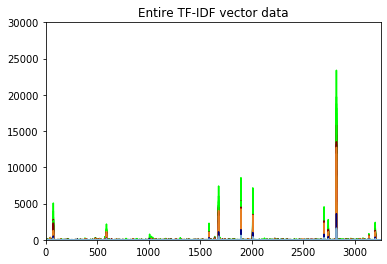

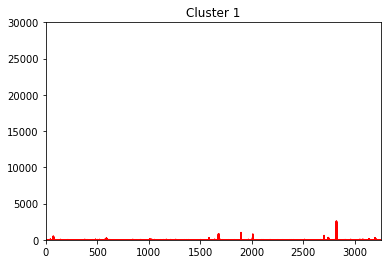

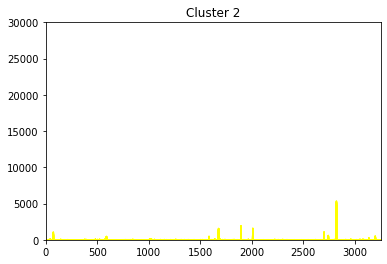

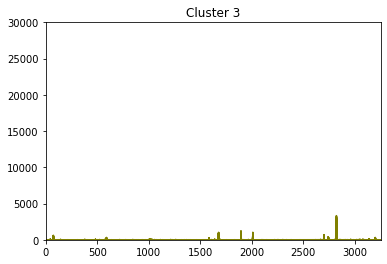

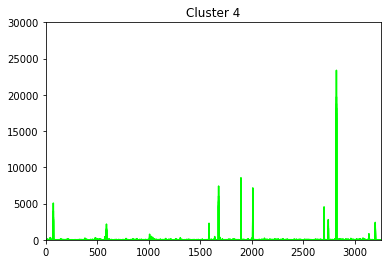

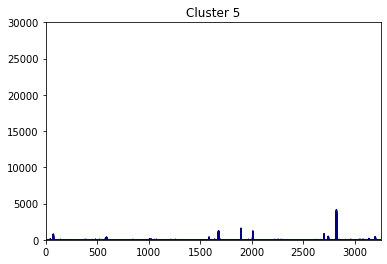

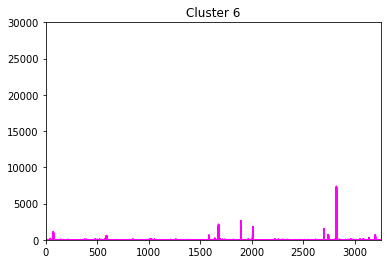

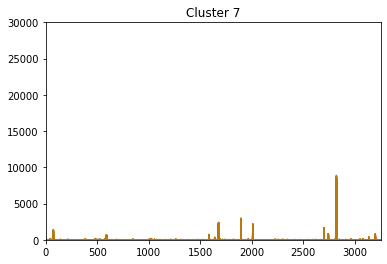

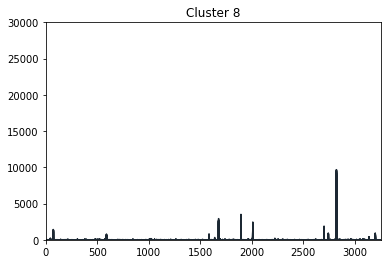

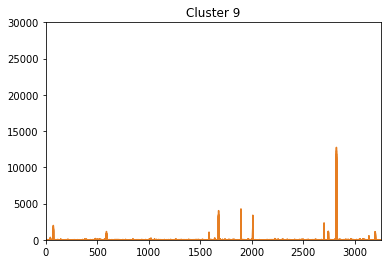

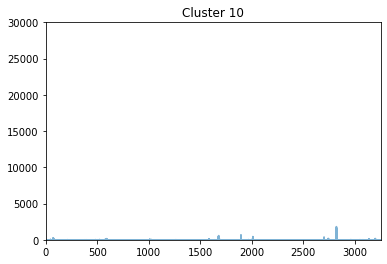

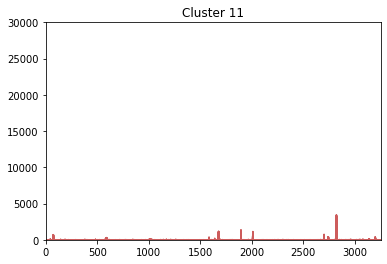

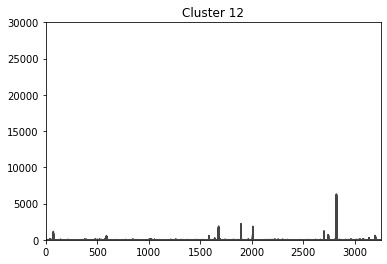

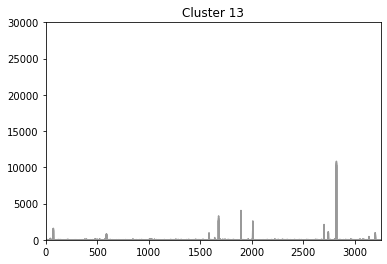

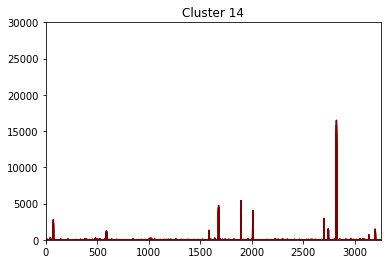

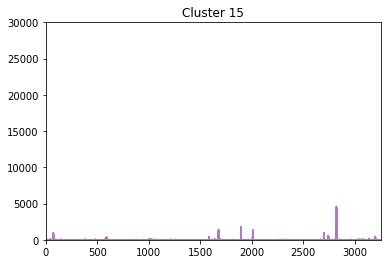

In [19]:
k = 15
iteration = 50
np.random.seed(1234)

vectors = np.zeros((len(speech), len(speech[0]["tfidf"])))

for i in range(len(speech)):
    vectors[i] = speech[i]["tfidf"]

# Shuffled the rows (vectors) randomly, so this is equivalent to drawing
np.random.shuffle(vectors)
centers = vectors[:k]

# for plotting: chose some colors that would match each culster
color_dict = {0: "#FF0000", 1: "#FFFF00", 2: "#808000", 3: "#00FF00",
              4: "#000080", 5: "#FF00FF", 6: "#B9770E", 7: "#1C2833",
              8: "#E67E22", 9: "#7FB3D5", 10: "#CD5C5C", 11: "#454545",
              12: "#999999", 13: "#800000", 14: "#AF7AC5"}

for i in range(iteration):
    
    model = KMeans(n_clusters = k, init = centers, n_init = 1, max_iter = 1)
    sou_cluster = model.fit(vectors)
    centers = model.cluster_centers_

match = model.predict(vectors)

df = pd.DataFrame(np.transpose(vectors), columns = match)
df.plot(color = [color_dict.get(x, "#333333") for x in df.columns], 
        legend = False, title = "Entire TF-IDF vector data", ylim = (0, 30000))
                            
for i in range(k):
    
    groupdf = df[i]
    groupdf.plot(color = color_dict[i], legend = False,
                 title = "Cluster {:d}".format(i+1), ylim = (0, 30000))

One remarkable point from the clustering resultls is that graphs have "spikes" at almost the same the x-axis points/regions (i.e. coordinate # within the TF-IDF vector) across clusters, regardless of the k value. However, magnitude/intensity of spikes at those points differed greatly across different clusters. (all graphs are set to have the same y-axis scale in order to make visual comparison among them valid)  
Considering that each coordinate value of a TF-IDF vector represents the weight each document has given to each word, we could roughly interpret the above observation to something like: "while words of more weights were same / similar across all SOUs, degree/magnitude of weights on those words significantly differed so that SOUs can be well categorized into clusters based on 'intensity of spikes.'"  
  
Of course, we should still be careful to derive firm conclusion since TF-IDF vectors and therefore clustering results could be affected when different word-splitting and vocabulary choice rules are adopted. (i.e. interpretable, but requires caution)